In [2]:
import os
from osgeo import gdal
import richdem as rd
from osgeo import ogr

import numpy as np
import rasterio
import rasterstats
import matplotlib
import geopandas as gpd
import fiona

import richdem as rd
import rioxarray as rxr
import matplotlib.pyplot as plt

from rasterstats import zonal_stats
from rasterio.plot import show_hist
from shapely.ops import cascaded_union
from shapely.geometry import shape
from shapely.geometry import box

#For advanced "print" options (printmd)
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [3]:
import sys
print(sys.path)

['C:\\fin_project\\softwareDev_finProject-main', 'C:\\Users\\victo\\anaconda3\\envs\\finalproject\\python310.zip', 'C:\\Users\\victo\\anaconda3\\envs\\finalproject\\DLLs', 'C:\\Users\\victo\\anaconda3\\envs\\finalproject\\lib', 'C:\\Users\\victo\\anaconda3\\envs\\finalproject', '', 'C:\\Users\\victo\\anaconda3\\envs\\finalproject\\lib\\site-packages', 'C:\\Users\\victo\\anaconda3\\envs\\finalproject\\lib\\site-packages\\win32', 'C:\\Users\\victo\\anaconda3\\envs\\finalproject\\lib\\site-packages\\win32\\lib', 'C:\\Users\\victo\\anaconda3\\envs\\finalproject\\lib\\site-packages\\Pythonwin']


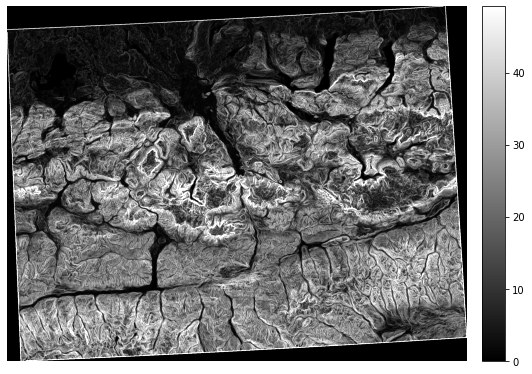

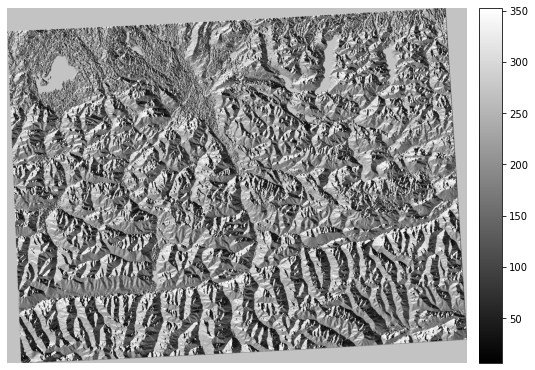

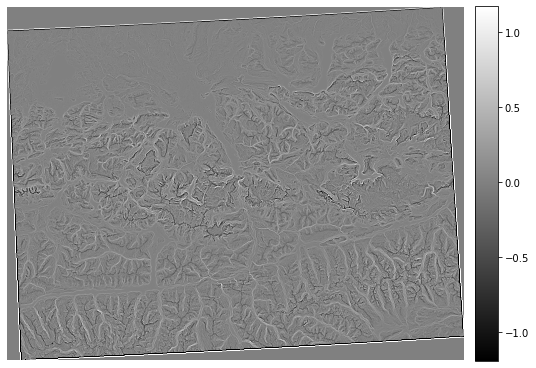

In [4]:
## reproject crs from testdata
input_raster = gdal.Open('testdata.tif')
output_raster = './results/testdata_EPSG25832.tif'
warp = gdal.Warp(output_raster,input_raster,dstSRS='EPSG:25832')

testdata = rd.LoadGDAL("./results/testdata_EPSG25832.tif", no_data=-9999)

## calculate slope, aspect, curvature
slope = rd.TerrainAttribute(testdata, attrib='slope_degrees', zscale=1)
aspect = rd.TerrainAttribute(testdata, attrib='aspect', zscale=1.0)
# curvature = rd.TerrainAttribute(testdata, attrib='curvature', zscale=1)
# planform_curvature = rd.TerrainAttribute(testdata, attrib='planform_curvature', zscale=1)
profile_curvature = rd.TerrainAttribute(testdata, attrib='profile_curvature', zscale=1)

## show results
rd.rdShow(slope, axes=False, cmap='gray', figsize=(8,5.5))
rd.rdShow(aspect, axes=False, cmap='gray', figsize=(8,5.5))
# rd.rdShow(curvature, axes=False, cmap='gray', figsize=(8,5.5))
# rd.rdShow(planform_curvature, axes=False, cmap='gray', figsize=(8,5.5))
rd.rdShow(profile_curvature, axes=False, cmap='gray', figsize=(8,5.5))

## save results as tif
rd.SaveGDAL("./results/slope.tif", slope)
rd.SaveGDAL("./results/aspect.tif", aspect)
# rd.SaveGDAL("./results/curvature.tif", curvature)
# rd.SaveGDAL("./results/planform_curvature.tif", planform_curvature)
rd.SaveGDAL("./results/profile_curvature.tif", profile_curvature)

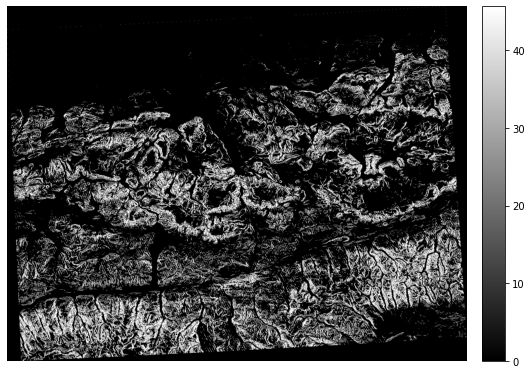

{'vmin': 0.0, 'vmax': 45.660301208496094}

In [5]:
## calculate slope with angles ranging from 28 to 54 degrees
cmd = 'gdal_calc.py --calc="A*logical_and(A>=28,A<=54)" --outfile=./results/slope_relevant.tif -A ./results/slope.tif --NoDataValue=0'
os.system(cmd)

## colorize relevant slope
cmd1 = 'gdaldem color-relief ./results/slope_relevant.tif color_slope_gradient.txt ./results/slope_relevant_color.tif -nearest_color_entry -alpha'
os.system(cmd1)

## generate hillshade
cmd2 = 'gdaldem hillshade ./results/testdata_EPSG25832.tif ./results/hillshade.tif'
os.system(cmd2)

## colorize aspect in cardinal directions N=green, E=red, S=violett, W=yellow
cmd3 = 'gdaldem color-relief ./results/aspect.tif color_aspect_cardinal_directions.txt ./results/aspect_color.tif -nearest_color_entry'
os.system(cmd3)

## calculate profile curvature >0
cmd4 = 'gdal_calc.py --calc="A*(A<0)" --outfile=./results/profile_curvature_relevant.tif -A ./results/profile_curvature.tif --NoDataValue=0'
os.system(cmd4)

## combine profile_curvature_color with hillshade
cmd5 = 'gdal_merge.py -separate -n -9999 -o ./results/new_rgb.tif ./results/profile_curvature_relevant.tif ./results/hillshade.tif'
os.system(cmd5)

## load and show slope_relevant.tif
slope_relevant =  rd.LoadGDAL("./results/slope_relevant.tif", no_data=-9999)
rd.rdShow(slope_relevant, axes=False, cmap='gray', figsize=(8,5.5))

In [6]:
src = gdal.Open('./results/slope_relevant_color.tif')
addlBand = gdal.Open('./results/hillshade.tif')
newBand = addlBand.GetRasterBand(1).ReadAsArray()

tmp = gdal.GetDriverByName('MEM').CreateCopy('', src, 0)
# tmp.AddBand()
tmp.GetRasterBand(4).WriteArray(newBand)

dst = gdal.GetDriverByName('GTiff').CreateCopy('./results/combined_profCurv_hillsh.tif', tmp, 0)
del dst

In [7]:
## create vector polygons from relevant area
cmd6 = 'gdal_polygonize.py ./results/slope_relevant.tif -b 1 ./results/slope_relevant.shp slope area'
os.system(cmd6)

## calculate area
cmd7 = 'ogrinfo -sql "SELECT SUM(OGR_GEOM_AREA) AS TOTAL_AREA FROM slope_relevant" ./results/slope_relevant.shp'
os.system(cmd7)

os.popen('ogrinfo -sql "SELECT SUM(OGR_GEOM_AREA) AS TOTAL_AREA FROM slope_relevant" ./results/slope_relevant.shp').read()

"INFO: Open of `./results/slope_relevant.shp'\n      using driver `ESRI Shapefile' successful.\n\nLayer name: slope_relevant\nGeometry: None\nFeature Count: 1\nLayer SRS WKT:\n(unknown)\nTOTAL_AREA: Real (0.0)\nOGRFeature(slope_relevant):0\n  TOTAL_AREA (Real) = 3206095679.01834\n\n"

In [8]:
# Define the Path of the Slope tif for Slope analysis

slope_analysis = "./results/slope_relevant.tif"

In [9]:
dataset_slope = rasterio.open(slope_analysis)
print(dataset_slope)

<open DatasetReader name='./results/slope_relevant.tif' mode='r'>


In [11]:
# Define the Path of the DEM for DEM analysis

dem_analysis = "./results/testdata_EPSG25832.tif"

In [12]:
dataset_dem = rasterio.open(dem_analysis)
print(dataset_dem)

<open DatasetReader name='./results/testdata_EPSG25832.tif' mode='r'>


In [13]:
#Show propoerties of selected Raster
img_name = dataset_slope.name
printmd("**Properties of the Image with the filename:** {n}\n".format(n=img_name))

num_bands = dataset_slope.count
print('Number of bands in image: {n}\n'.format(n=num_bands))

rows, cols = dataset_slope.shape
print('Image size is: {r} rows x {c} columns\n'.format(r=rows, c=cols))

desc = dataset_slope.descriptions
metadata = dataset_slope.meta

print('Raster description: {desc}\n'.format(desc=desc))

driver = dataset_slope.driver
print('Raster driver: {d}\n'.format(d=driver))

proj = dataset_slope.crs
print('Image projection:')
print(proj, '\n')

gt = dataset_slope.transform

print('Image geo-transform:\n{gt}\n'.format(gt=gt))

print('All raster metadata:')
print(metadata)
print('\n')

**Properties of the Image with the filename:** ./results/slope_relevant.tif


Number of bands in image: 1

Image size is: 1527 rows x 1980 columns

Raster description: (None,)

Raster driver: GTiff

Image projection:
EPSG:25832 

Image geo-transform:
| 69.95, 0.00, 743185.09|
| 0.00,-69.95, 5328879.31|
| 0.00, 0.00, 1.00|

All raster metadata:
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 1980, 'height': 1527, 'count': 1, 'crs': CRS.from_epsg(25832), 'transform': Affine(69.94775638389548, 0.0, 743185.090039658,
       0.0, -69.94775638389548, 5328879.312031286)}




In [14]:
#Show propoerties of selected Raster

img_name = dataset_dem.name
printmd("**Properties of the Image with the filename:** {n}\n".format(n=img_name))

num_bands = dataset_dem.count
print('Number of bands in image: {n}\n'.format(n=num_bands))

rows, cols = dataset_dem.shape
print('Image size is: {r} rows x {c} columns\n'.format(r=rows, c=cols))

desc = dataset_dem.descriptions
metadata = dataset_slope.meta

print('Raster description: {desc}\n'.format(desc=desc))

driver = dataset_dem.driver
print('Raster driver: {d}\n'.format(d=driver))

proj = dataset_dem.crs
print('Image projection:')
print(proj, '\n')

gt = dataset_dem.transform

print('Image geo-transform:\n{gt}\n'.format(gt=gt))

print('All raster metadata:')
print(metadata)
print('\n')

**Properties of the Image with the filename:** ./results/testdata_EPSG25832.tif


Number of bands in image: 1

Image size is: 1527 rows x 1980 columns

Raster description: (None,)

Raster driver: GTiff

Image projection:
EPSG:25832 

Image geo-transform:
| 69.95, 0.00, 743185.09|
| 0.00,-69.95, 5328879.31|
| 0.00, 0.00, 1.00|

All raster metadata:
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 1980, 'height': 1527, 'count': 1, 'crs': CRS.from_epsg(25832), 'transform': Affine(69.94775638389548, 0.0, 743185.090039658,
       0.0, -69.94775638389548, 5328879.312031286)}




In [15]:
#Input for the Raster Statistics
nir = dataset_slope.read(1)

#Generate Statistics
band_mean = np.mean(nir) 
band_min = np.amin(nir)
band_max = np.amax(nir)
band_stddev = np.std(nir)

printmd ('**Statistics of Slope Raster:**')
print('range of selected Band: {minimum} - {maximum}'.format(maximum=band_max,
                                                 minimum=band_min))
print('mean of selected Band: {m}'.format(m=band_mean))
print('stdev of selected Band: {s}'.format(s=band_stddev))

**Statistics of Slope Raster:**

range of selected Band: 0.0 - 53.999725341796875
mean of selected Band: 7.810324668884277
stdev of selected Band: 15.12012004852295


In [16]:
# Input for the Raster Statistics
nir1 = dataset_dem.read(1)

# Generate Statistics
band_mean = np.mean(nir1) 
band_min = np.amin(nir1)
band_max = np.amax(nir1)
band_stddev = np.std(nir1)

printmd ('**Statistics of DEM Raster:**')
print('range of selected Band: {minimum} - {maximum}'.format(maximum=band_max,
                                                 minimum=band_min))
print('mean of selected Band: {m}'.format(m=band_mean))
print('stdev of selected Band: {s}'.format(s=band_stddev))

**Statistics of DEM Raster:**

range of selected Band: 0 - 3627
mean of selected Band: 1056.590616379909
stdev of selected Band: 633.9268654247077


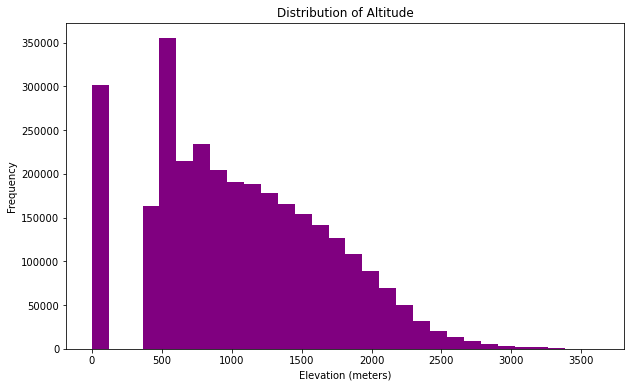

In [18]:
# Define the input for the histogram
dem_im = rxr.open_rasterio(dem_analysis, masked=True)

# Plot the histogram
f, ax = plt.subplots(figsize=(10, 6))
dem_im.plot.hist(ax=ax,
                       color="purple",
                       bins=30)
ax.set(title="Distribution of Altitude",
       xlabel='Elevation (meters)',
       ylabel='Frequency')
plt.show()

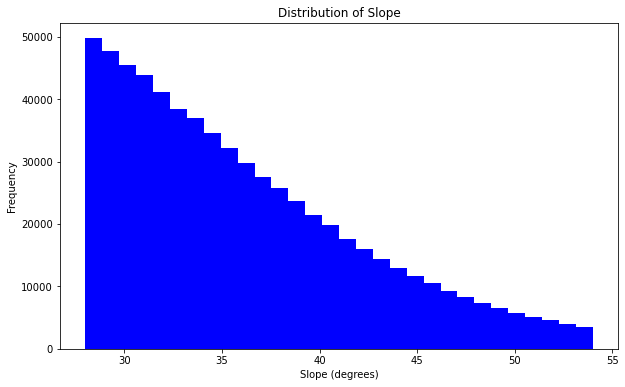

In [19]:
# Define the input for the histogram
slope_im = rxr.open_rasterio(slope_analysis, masked=True)

# Plot the histogram
f, ax = plt.subplots(figsize=(10, 6))
slope_im.plot.hist(ax=ax,
                       color="blue",
                       bins=30)
ax.set(title="Distribution of Slope",
       xlabel='Slope (degrees)',
       ylabel='Frequency')
plt.show()

**Checking the selected Polygons for Zonal Statistic:**

   Shape_Leng  Shape_Area            Type  \
0    0.995679    0.024233          Forest   
1    0.000000    0.000000  Populated Area   

                                            geometry  
0  POLYGON Z ((12.80574 47.63102 0.00000, 12.8212...  
1  POLYGON Z ((13.16349 47.60323 0.00000, 13.1674...  


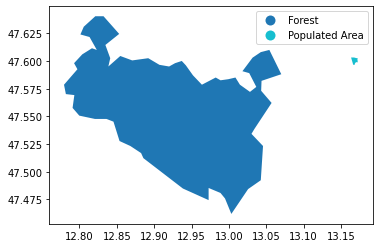

In [20]:
#ZONAL STATISTICS 1: ZONAL STATISTICS FOR DEFINED STUDY AREAS / AREAZONAL.SHP

# Before calculating the zonal statistics, checking if the slected polygons (zones) are valid. 

printmd ('**Checking the selected Polygons for Zonal Statistic:**')

gdf = gpd.read_file('areazonal.shp')

%matplotlib inline
gdf.plot(column='Type', cmap=None, legend=True)

print (gdf)

In [25]:
#... TESTING ZONAL STATISTICS FOR COMBINED MULTIPLE POLYGONS

# use the GeoSeries.unary_union Function of Geopanda to show the union of all geometries in the GeoSeries
src1 = fiona.open('areazonal.shp')
geoms1 = [shape(feature['geometry']) for feature in src1]

m1 = gpd.GeoSeries(geoms1)

union1 = m1.unary_union

printmd("**Zonal statistics for both study areas combined:**")
zonal_stats([union1], "testdata.tif", nodata=np.nan,
            stats="count min mean max median nodata range")

**Zonal statistics for both study areas combined:**

[{'min': 465.0,
  'max': 2668.0,
  'mean': 1528.7835169552154,
  'count': 34945,
  'median': 1575.0,
  'range': 2203.0,
  'nodata': 0.0}]

**Checking the selected Area for Zonal Statistic:**

        area                                           geometry
0         49  POLYGON ((873427.812 5328879.312, 873497.760 5...
1         48  POLYGON ((872308.648 5328809.364, 872378.596 5...
2         49  POLYGON ((874546.977 5328809.364, 874616.924 5...
3         49  POLYGON ((871259.432 5328739.417, 871329.380 5...
4         49  POLYGON ((873497.760 5328739.417, 873567.708 5...
...      ...                                                ...
556104    41  POLYGON ((748221.328 5222208.984, 748291.276 5...
556105    31  POLYGON ((747941.537 5222139.036, 748011.485 5...
556106    34  POLYGON ((748011.485 5222139.036, 748081.433 5...
556107    30  POLYGON ((748151.381 5222139.036, 748221.328 5...
556108    32  POLYGON ((748221.328 5222139.036, 748291.276 5...

[556109 rows x 2 columns]


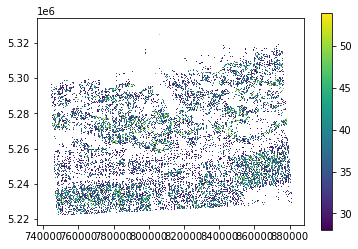

In [27]:
#ZONAL STATISTICS 2: ZONAL STATISTICS FOR THE RESULTS/SLOPE_RELEVANT.SHP
# Before calculating the zonal statistics, checking if the slected polygons (zones) are valid. 

printmd ('**Checking the selected Area for Zonal Statistic:**')

gdf = gpd.read_file('results/slope_relevant.shp')

%matplotlib inline
gdf.plot(column='area', cmap=None, legend=True)

print (gdf)

In [28]:
# use the GeoSeries.unary_union Function of Geopanda to show the union of all geometries in the GeoSeries

src = fiona.open('results/slope_relevant.shp')
geoms = [shape(feature['geometry']) for feature in src]

m = gpd.GeoSeries(geoms)

union = m.unary_union

In [29]:
#calculate the actual zonal statistics

printmd("**Zonal statistics for the area with relevant slope values in the raster with the filename:** {n}\n".format(n=img_name))
zonal_stats([union], "./results/testdata_EPSG25832.tif", nodata=np.nan,
            stats="count min mean max median nodata range")

**Zonal statistics for the area with relevant slope values in the raster with the filename:** ./results/testdata_EPSG25832.tif


[{'min': 0.0,
  'max': 3581.0,
  'mean': 1498.445753971948,
  'count': 655283,
  'median': 1450.0,
  'range': 3581.0,
  'nodata': 0.0}]